# Preprocessing and Pipelines

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
music_df = pd.read_csv('music.csv')

## Preprocessing data

### Creating dummy variables

In [6]:
# Create music_dummies
music_dummies = pd.get_dummies(music_df, drop_first=True)

# Print the new DataFrame's shape
print("Shape of music_dummies: {}".format(music_dummies.shape))

Shape of music_dummies: (1000, 20)


### Regression with categorical features

In [9]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
# Create X and y
X = music_dummies.drop('popularity', axis=1).values
y = music_dummies['popularity'].values

# Instantiate a ridge model
ridge = Ridge(alpha=0.2)

# Perform cross-validation
scores = cross_val_score(ridge, X, y, cv=kf, scoring="neg_mean_squared_error")

# Calculate RMSE
rmse = np.sqrt(-scores)
print("Average RMSE: {}".format(np.mean(rmse)))
print("Standard Deviation of the target array: {}".format(np.std(y)))

Average RMSE: 8.236853840202285
Standard Deviation of the target array: 14.02156909907019


## Handling missing data

### Dropping missing data

In [44]:
music_df = pd.read_csv('music.csv')
# Print missing values for each column
print(music_df.isna().sum().sort_values())

# Remove values where less than 5% are missing
music_df = music_df.dropna(subset=['genre', 'popularity', 'loudness', 'liveness', 'tempo'])

# Convert genre to a binary feature
music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

print(music_df.isna().sum().sort_values())
print("Shape of the `music_df`: {}".format(music_df.shape))

popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64
Shape of the `music_df`: (1000, 12)


### Pipeline for song genre prediction: I

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [22]:
# Import modules
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Instantiate an imputer
imputer = SimpleImputer()

# Instantiate a knn model
knn = KNeighborsClassifier(n_neighbors=3)

# Build steps for the pipeline
steps = [("imputer", imputer), 
         ("knn", knn)]

### Pipeline for song genre prediction: II

In [45]:
from sklearn.metrics import confusion_matrix

music_df = pd.read_csv('music.csv')

music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

music_dummies = pd.get_dummies(music_df, drop_first=True)

# music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

X = music_dummies.drop('genre', axis=1).values
y = music_dummies['genre'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

imp_mean = SimpleImputer()

In [47]:
steps = [("imputer", imp_mean),
        ("knn", knn)]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[45 50]
 [43 62]]


## Centering and scaling

### Centering and scaling for regression

In [48]:
from sklearn.linear_model import Lasso

music_df = pd.read_csv('music.csv')

music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

music_dummies = pd.get_dummies(music_df, drop_first=True)

X = music_dummies.drop('loudness', axis=1).values
y = music_dummies['loudness'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [49]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Create pipeline steps
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=0.5))]

# Instantiate the pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Calculate and print R-squared
print(pipeline.score(X_test, y_test))

0.6944040859309658


### Centering and scaling for classification

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso

music_df = pd.read_csv('music.csv')

music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

music_dummies = pd.get_dummies(music_df, drop_first=True)

X = music_dummies.drop('genre', axis=1).values
y = music_dummies['genre'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [55]:
# Build the steps
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)

# Create the parameter space
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=21)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
print(cv.best_score_, "\n", cv.best_params_)

0.8487499999999999 
 {'logreg__C': 0.7896842105263158}


## Evaluating multiple models

### Visualizing regression model performance

In [56]:
from sklearn.linear_model import LinearRegression

/tmp/ipykernel_218077/1686131521.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=models.keys())


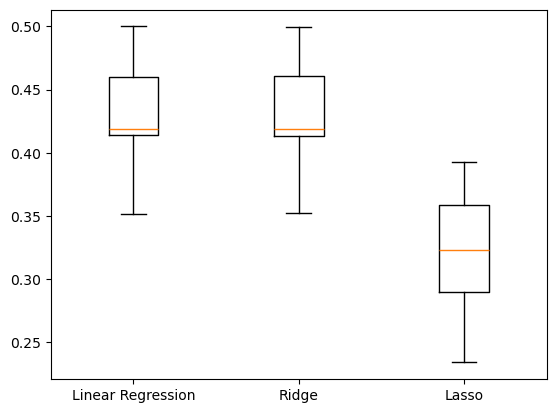

In [ ]:
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1)}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

### Predicting on the test set

In [58]:
# Import mean_squared_error
from sklearn.metrics import mean_squared_error

for name, model in models.items():
  
  # Fit the model to the training data
  model.fit(X_train_scaled, y_train)
  
  # Make predictions on the test set
  y_pred = model.predict(X_test_scaled)
  
  # Calculate the test_rmse
  test_rmse = mean_squared_error(y_test, y_pred, squared=False)
  print("{} Test Set RMSE: {}".format(name, test_rmse))

NameError: name 'X_train_scaled' is not defined

### Visualizing classification model performance

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Create models dictionary
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(),
"Decision Tree Classifier": DecisionTreeClassifier()}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=6, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
  results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.show()

### Pipeline for predicting song popularity

In [63]:
# Create steps
steps = [("imp_mean", SimpleImputer()), 
         ("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]

# Set up pipeline
pipeline = Pipeline(steps)
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 1.0, 10)}

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(X_test, y_test)))

Tuned Logistic Regression Parameters: {'logreg__C': 0.778, 'logreg__solver': 'saga'}, Accuracy: 0.855
